In [1]:
from qpe_jax import *

import numpy
from numpy.random import uniform, normal

from scipy.stats import unitary_group
from scipy.optimize import minimize

from functools import reduce
from itertools import product
from time import time

import pickle

import matplotlib.pyplot as plt

# Work --- many runs

## Dataset preparation

In [2]:
# ham_func = transverse_cluster_ham_reparametrized_sparse; ham_name = "t_cluster_par"
ham_func = ising_ham_sparse; ham_name = "ising_ham"
# ham_func = schwinger_ham_sparse; ham_name = "schwinger_ham"
ham_args = []


n_inp = 4
a = 0.05
b = 2

In [3]:
eps = 0
T = 5
V = 101

labels_train = jnp.linspace(a, b, T) + eps
svs_train = []
for p in labels_train:
    print(p, end="\r")
    ham = ham_func(n_inp, p, *ham_args)
    svs_train.append(sparse.linalg.eigsh(ham, k=1, which="SA")[1].reshape(-1))
svs_train = jnp.array(svs_train)

labels_test = jnp.linspace(a, b, V) + eps
svs_test = []
for p in labels_test:
    print(p, end="\r")
    ham = ham_func(n_inp, p, *ham_args)
    svs_test.append(sparse.linalg.eigsh(ham, k=1, which="SA")[1].reshape(-1))
svs_test = jnp.array(svs_test)

2.08050000000000026

## Measurements, copies, other parameters

In [35]:
n_copies = 1
n_tot = n_inp*n_copies

ansatz_func = hea
ansatz_name = "hea"
n_layers = 4
ansatz_info = "-l=%d" % n_layers
n_pars_ans = 3*n_layers*n_tot
ansatz_args = [n_layers, n_tot]

# ansatz_func = qcnn_schwinger
# ansatz_name = "qcnn_schwinger"
# ansatz_info = ""
# ansatz_args = [n_tot]
# n_pars_ans = 21*int(np.log2(n_tot))

# ansatz_func = qcnn_cluster_9q
# ansatz_name = "qcnn_cluster_9q"
# ansatz_info = ""
# n_pars_ans = 16
# ansatz_args = []


# n_meas_list = [0]
# n_meas_list = [3, 4]
# n_meas_list = [4]
# n_meas_list = [3, 4, 5]
n_meas_list = [i for i in range(n_tot)]

d = 2**n_tot 
n_pars_est = 2**len(n_meas_list) # number of eigenvalues x_i

w_ls = 1e0
w_var = 1e-4

In [36]:
basis = product([jnp.array([1, 0]), jnp.array([0, 1])], repeat=len(n_meas_list))
projs = []
for line in basis:
    proj = [jnp.ones(2)]*n_tot
    for q in range(len(n_meas_list)):
        proj[n_meas_list[q]] = line[q]
    proj = reduce(jnp.kron, proj)
    projs.append(proj)
projs = jnp.array(projs)

svs_cop = [reduce(jnp.kron, [sv]*n_copies) for sv in svs_train]

## Optimization

In [37]:
@jax.jit
def fun(x):
    x_ans, x_est = x[:n_pars_ans], x[n_pars_ans:] # parameters x_i and theta_i
    H = jnp.zeros(d, dtype=complex)
    for q in range(len(x_est)):
        H += x_est[q]*projs[q]
    U_svs = ansatz_func(x_ans, svs_cop, *ansatz_args)
    HU_svs = H*U_svs
    expecs = jnp.sum(U_svs.conj()*HU_svs, axis=1).real
    disps = jnp.sum(HU_svs.conj()*HU_svs, axis=1).real - expecs**2
    f = w_ls*jnp.sum((expecs - labels_train)**2) # least squares
    f += w_var*jnp.sum(disps) # sum of variances
    return f

def callback(x):
    niter[0] += 1
    print("\t\t\tIteration: %d | Time passed: %d s" %(niter[0], time() - time_start), end="\r")
    return None

method = "BFGS"

In [ ]:
n_runs = 1

pars_list = []
times_list = []
for r in range(n_runs):
    print("r:", r)

    time_start = time()
    niter = [0]
    x0 = jnp.concatenate([uniform(0, 2*jnp.pi, n_pars_ans), normal(0, 1, n_pars_est)])
    
    result = minimize(fun, x0, method=method, callback=callback)
    pars = result.x

    time_finish = time() - time_start

    print("\n\t Finished in %.2f s" % time_finish)
    print("\t Cost: %f" % result.fun)
    
    pars_list.append(pars)
    times_list.append(time_finish)

r: 0
			Iteration: 416 | Time passed: 973 s

In [ ]:
# n_runs = 10

# lr = 0.01
# n_iter = 30000
# gtol = 1e-5

# fvals_list = []
# pars_list = []
# times_list = []
# for r in range(n_runs):
#     print("r:", r)
#     time_start = time()
    
#     x0 = jnp.array(uniform(-1, 1, n_pars_ans + n_pars_est))
    
#     pars = jnp.array(x0)

#     solver = optax.adamw(learning_rate=lr)
#     opt_state = solver.init(pars)
#     fval_min = 1e10 # just a large number
#     fvals = []

#     for i in range(n_iter):
#         fval, grad = jax.value_and_grad(fun)(pars)
#         updates, opt_state = solver.update(grad, opt_state, pars)
#         pars = optax.apply_updates(pars, updates)
#         gnorm = jnp.linalg.norm(grad)
#         fvals.append(fval)
#         print(f"\t Step: {i} | Loss: {fval} | gnorm: {gnorm}", end="\r")
#         if fval < fval_min:
#             fval_min = fval
#             pars_min = pars
#         if gnorm < gtol:
#             break
    
#     time_finish = time() - time_start

#     print("\n\t Finished in %.2f s" % time_finish)
    
#     fvals_list.append(fvals)
#     pars_list.append(pars_min)
#     times_list.append(time_finish)

In [ ]:
# %%time
# """ !!!Eats a hell lot of memory!!! """
# """ Polish the solution with L-BFGS """
# n_iter = 10
# gtol = 1e-5

# # pars = jnp.array(x0)
# pars = jnp.array(pars_min)

# solver = optax.lbfgs()
# opt_state = solver.init(pars)
# value_and_grad = optax.value_and_grad_from_state(fun)

# for i in range(n_iter):
#     value, grad = value_and_grad(pars, state=opt_state)
#     updates, opt_state = solver.update(grad, opt_state, pars, value=value, grad=grad, value_fn=fun)
#     pars = optax.apply_updates(pars, updates)
#     gnorm = jnp.linalg.norm(grad)
#     print(f"Step: {i} | Loss: {fval} | gnorm: {gnorm}", end="\r")
#     if gnorm < gtol:
#         break
# print()

## Infer and plot

In [ ]:
dp = 1e-5
expecs_list = []
expecs_der_list = []
disps_list = []
CFIs_list = []
biass_list = []
for r in range(n_runs):
    print("r:", r)
    expecs_test, expecs_der_test, disps_test, CFIs_test, QFIs_test = aux_info(ham_func, labels_test, ham_args, ansatz_func, ansatz_args, n_inp, pars_list[r], n_meas_list=n_meas_list, n_copies=n_copies, dp=dp)
    biass_test = expecs_test - labels_test
    expecs_list.append(expecs_test)
    expecs_der_list.append(expecs_der_test)
    disps_list.append(disps_test)
    CFIs_list.append(CFIs_test)
    biass_list.append(biass_test)

In [ ]:
# expecs_mean = jnp.mean(expecs_list, axis=0)
# expecs_der_mean = jnp.mean(expecs_der_list, axis=0)
disps_mean = numpy.mean(jnp.array(disps_list), axis=0)
disps_red_mean = numpy.mean(numpy.array(disps_list)/numpy.array(expecs_der_list)**2, axis=0)
disps_red_std = numpy.std(numpy.array(disps_list)/numpy.array(expecs_der_list)**2, axis=0)
CFIs_mean = numpy.mean(numpy.array(CFIs_list), axis=0)
biass_sq_mean = numpy.mean((numpy.array(expecs_list) - labels_test)**2, axis=0)
biass_sq_std = numpy.std((numpy.array(expecs_list) - labels_test)**2, axis=0)

In [ ]:
biass_sq_fill_l = numpy.array(biass_sq_mean - biass_sq_std)
biass_sq_fill_l = numpy.array([biass_sq_fill_l[i] if biass_sq_fill_l[i] > 0 else 0 for i in range(V)])
biass_sq_fill_u = numpy.array(biass_sq_mean + biass_sq_std)
disps_red_fill_l = numpy.array(disps_red_mean - disps_red_std)
disps_red_fill_l = numpy.array([disps_red_fill_l[i] if disps_red_fill_l[i] > 1/QFIs_test[i] else 1/QFIs_test[i] for i in range(V)])
disps_red_fill_u = numpy.array(disps_red_mean + disps_red_std)

In [ ]:
print("Average MSE:                   ", sum(biass_sq_mean)/V)
print("Average total variance:        ", sum(disps_mean)/V)
print("Average total variance reduced:", sum(disps_red_mean)/V)

plt.figure(figsize=(6, 4))
# plt.scatter(labels_train, biass_train**2, s=100)
plt.plot(labels_test, biass_sq_mean)
plt.fill_between(labels_test, biass_sq_fill_l, biass_sq_fill_u, alpha=0.35, color="tab:blue")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$(\mathsf{a} - \alpha)^2$")
# plt.legend()
plt.grid()
# plt.savefig(save_path + file_info + postfix + "-est.pdf", transparent=True, bbox_inches='tight')
plt.show()

plt.figure(figsize=(6, 4))
# plt.scatter(labels_train, disps_train/expecs_der_train**2, s=150, zorder=10)
plt.plot(labels_test, disps_red_mean, zorder=10)
plt.fill_between(labels_test, disps_red_fill_l, disps_red_fill_u, alpha=0.35, color="tab:blue")
plt.plot(numpy.sort(labels_test), 1/QFIs_test, color="C2", label=r"$\frac{1}{I_q}$", linewidth=5, linestyle="solid") # , color="tab:blue"
plt.plot(numpy.sort(labels_test), 1/CFIs_mean, label=r"$\frac{1}{I_c}$", linewidth=1.5, linestyle="dashed", zorder=12) # , color="tab:red"
plt.ylabel(r"$\frac{\Delta^2 H}{|\partial_\alpha \langle H \rangle |^2}$" )
plt.xlabel(r"$\alpha$")
plt.grid()
# plt.yscale("log")
plt.legend()
# plt.savefig(save_path + file_info + postfix + "-var.pdf", transparent=True, bbox_inches='tight')
plt.show()

Average MSE:                    0.0012224310967540754
Average total variance:         14.702109605115798
Average total variance reduced: 17.445275325232064


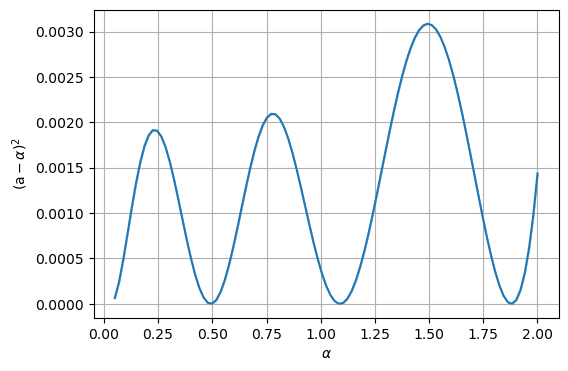

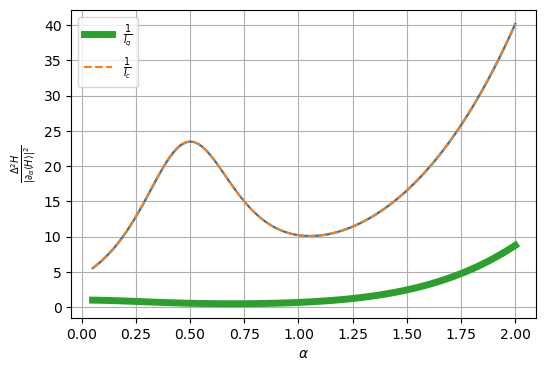

In [29]:
path = f"/home/investigator/Work/qcnn-var/Results/{ham_name}/"
info = f"{ham_name}-{ansatz_name}{ansatz_info}-" + ("n=%d-c=%d-m=%s-r=%d-w_ls=%.1f-w_var=%.4f" %(n_inp, n_copies, n_meas_list, n_runs, w_ls, w_var)).replace(" ", "")
path + info

'/home/investigator/Work/qcnn-var/Results/ising_ham/ising_ham-hea-l=3-n=4-c=1-m=[0]-r=1-w_ls=1.0-w_var=0.0001'

In [104]:
data_dict = {
    "n": n_inp,
    "c": n_copies,
    "a": a,
    "b": b,
    "n_runs": n_runs,
    "w_ls": w_ls, 
    "w_var": w_var, 
    "labels_train": numpy.array(labels_train),
    "labels_test": numpy.array(labels_test),
    # "n_iter": n_iter,
    "n_runs": n_runs,
    "pars_list": numpy.array(pars_list),
    "expecs_list": numpy.array(expecs_list),
    "expecs_der_list": numpy.array(expecs_der_list),
    "CFIs_list": numpy.array(CFIs_list),
    "QFIs": numpy.array(QFIs_test),
    "disps_list": numpy.array(disps_list),
    "times_list": numpy.array(times_list),
    "ham_name": ham_name,
    "ansatz_name": ansatz_name,
    "ansatz_info": ansatz_info[1:],
    # "note": "Method: %s. Ansatz: QCNN from https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.5.043250" %method, 
    # "note": "Method: %s. Ansatz: QCNN from https://onlinelibrary.wiley.com/doi/10.1002/qute.202400325" %method, 
} 
# https://onlinelibrary.wiley.com/doi/10.1002/qute.202400325
# https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.5.043250


with open(path + info + ".dict", 'wb') as fp:
    pickle.dump(data_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)

# Load and plot

In [22]:
import numpy
from numpy import array, mean, std
import pickle
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family']='serif'
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams.update({'font.size': 20})
matplotlib.rc('text', usetex=True)

In [2]:
path = "/home/kardashin/Work/QCNN-var/Results/Transverse_cluster_reparametrized/"

In [3]:
info = "t_cluster_par" + "-qcnn_cluster_9q-" + ("n=%d-c=%d-m=%s-r=%d-w_ls=%.1f-w_var=%.4f" %(9, 1, [4], 10, 1, 1e-4)).replace(" ", "")
print(path + info)
with open(path + info + ".dict", 'rb') as fp:
    data_dict_loaded = pickle.load(fp)

QFIs = data_dict_loaded["QFIs"]
labels_test = data_dict_loaded["labels_test"]

disps_mean_qcnn_4 = mean(data_dict_loaded["disps_list"], axis=0)
disps_red_mean_qcnn_4 = mean(data_dict_loaded["disps_list"]/data_dict_loaded["expecs_der_list"]**2, axis=0)
disps_red_std_qcnn_4 = std(data_dict_loaded["disps_list"]/data_dict_loaded["expecs_der_list"]**2, axis=0)
biass_sq_mean_qcnn_4 = mean((data_dict_loaded["expecs_list"] - data_dict_loaded["labels_test"])**2, axis=0)
biass_sq_std_qcnn_4 = std((data_dict_loaded["expecs_list"] - data_dict_loaded["labels_test"])**2, axis=0)
CFIs_mean_qcnn_4 = mean(data_dict_loaded["CFIs_list"], axis=0)

biass_sq_fill_l_qcnn_4 = array(biass_sq_mean_qcnn_4 - biass_sq_std_qcnn_4)
biass_sq_fill_l_qcnn_4 = array([biass_sq_fill_l_qcnn_4[i] if biass_sq_fill_l_qcnn_4[i] > 0 else 0 for i in range(len(biass_sq_fill_l_qcnn_4))])
biass_sq_fill_u_qcnn_4 = array(biass_sq_mean_qcnn_4 + biass_sq_std_qcnn_4)
disps_red_fill_l_qcnn_4 = array(disps_red_mean_qcnn_4 - disps_red_std_qcnn_4)
disps_red_fill_l_qcnn_4 = array([disps_red_fill_l_qcnn_4[i] if disps_red_fill_l_qcnn_4[i] > 1/QFIs[i] else 1/QFIs[i] for i in range(len(disps_red_fill_l_qcnn_4))])
disps_red_fill_u_qcnn_4 = array(disps_red_mean_qcnn_4 + disps_red_std_qcnn_4)

/home/kardashin/Work/QCNN-var/Results/Transverse_cluster_reparametrized/t_cluster_par-qcnn_cluster_9q-n=9-c=1-m=[4]-r=10-w_ls=1.0-w_var=0.0001


In [7]:
info = "t_cluster_par" + "-qcnn_cluster_9q-" + ("n=%d-c=%d-m=%s-r=%d-w_ls=%.1f-w_var=%.4f" %(9, 1, [3,4,5], 10, 1, 1e-4)).replace(" ", "")
print(path + info)
with open(path + info + ".dict", 'rb') as fp:
    data_dict_loaded = pickle.load(fp)

disps_mean_qcnn_345 = mean(data_dict_loaded["disps_list"], axis=0)
disps_red_mean_qcnn_345 = mean(data_dict_loaded["disps_list"]/data_dict_loaded["expecs_der_list"]**2, axis=0)
disps_red_std_qcnn_345 = std(data_dict_loaded["disps_list"]/data_dict_loaded["expecs_der_list"]**2, axis=0)
biass_sq_mean_qcnn_345 = mean((data_dict_loaded["expecs_list"] - data_dict_loaded["labels_test"])**2, axis=0)
biass_sq_std_qcnn_345 = std((data_dict_loaded["expecs_list"] - data_dict_loaded["labels_test"])**2, axis=0)
CFIs_mean_qcnn_345 = mean(data_dict_loaded["CFIs_list"], axis=0)

biass_sq_fill_l_qcnn_345 = array(biass_sq_mean_qcnn_345 - biass_sq_std_qcnn_345)
biass_sq_fill_l_qcnn_345 = array([biass_sq_fill_l_qcnn_345[i] if biass_sq_fill_l_qcnn_345[i] > 0 else 0 for i in range(len(biass_sq_fill_l_qcnn_345))])
biass_sq_fill_u_qcnn_345 = array(biass_sq_mean_qcnn_345 + biass_sq_std_qcnn_345)
disps_red_fill_l_qcnn_345 = array(disps_red_mean_qcnn_345 - disps_red_std_qcnn_345)
disps_red_fill_l_qcnn_345 = array([disps_red_fill_l_qcnn_345[i] if disps_red_fill_l_qcnn_345[i] > 1/QFIs[i] else 1/QFIs[i] for i in range(len(disps_red_fill_l_qcnn_345))])
disps_red_fill_u_qcnn_345 = array(disps_red_mean_qcnn_345 + disps_red_std_qcnn_345)

/home/kardashin/Work/QCNN-var/Results/Transverse_cluster_reparametrized/t_cluster_par-qcnn_cluster_9q-n=9-c=1-m=[3,4,5]-r=10-w_ls=1.0-w_var=0.0001


In [6]:
info = "t_cluster_par" + "-hva_transverse_cluster-" + ("n=%d-c=%d-m=%s-r=%d-w_ls=%.1f-w_var=%.4f" %(9, 1, [3,4,5], 10, 1, 1e-4)).replace(" ", "")
print(path + info)
with open(path + info + ".dict", 'rb') as fp:
    data_dict_loaded = pickle.load(fp)

disps_mean_hva_345 = mean(data_dict_loaded["disps_list"], axis=0)
disps_red_mean_hva_345 = mean(data_dict_loaded["disps_list"]/data_dict_loaded["expecs_der_list"]**2, axis=0)
disps_red_std_hva_345 = std(data_dict_loaded["disps_list"]/data_dict_loaded["expecs_der_list"]**2, axis=0)
biass_sq_mean_hva_345 = mean((data_dict_loaded["expecs_list"] - data_dict_loaded["labels_test"])**2, axis=0)
biass_sq_std_hva_345 = std((data_dict_loaded["expecs_list"] - data_dict_loaded["labels_test"])**2, axis=0)
CFIs_mean_hva_345 = mean(data_dict_loaded["CFIs_list"], axis=0)

biass_sq_fill_l_hva_345 = array(biass_sq_mean_hva_345 - biass_sq_std_hva_345)
biass_sq_fill_l_hva_345 = array([biass_sq_fill_l_hva_345[i] if biass_sq_fill_l_hva_345[i] > 0 else 0 for i in range(len(biass_sq_fill_l_hva_345))])
biass_sq_fill_u_hva_345 = array(biass_sq_mean_hva_345 + biass_sq_std_hva_345)
disps_red_fill_l_hva_345 = array(disps_red_mean_hva_345 - disps_red_std_hva_345)
disps_red_fill_l_hva_345 = array([disps_red_fill_l_hva_345[i] if disps_red_fill_l_hva_345[i] > 1/QFIs[i] else 1/QFIs[i] for i in range(len(disps_red_fill_l_hva_345))])
disps_red_fill_u_hva_345 = array(disps_red_mean_hva_345 + disps_red_std_hva_345)

/home/kardashin/Work/QCNN-var/Results/Transverse_cluster_reparametrized/t_cluster_par-hva_transverse_cluster-n=9-c=1-m=[3,4,5]-r=10-w_ls=1.0-w_var=0.0001


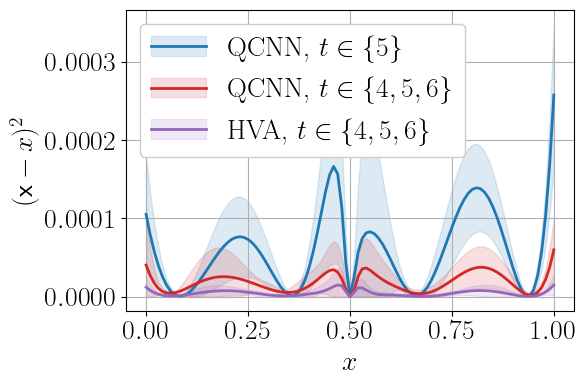

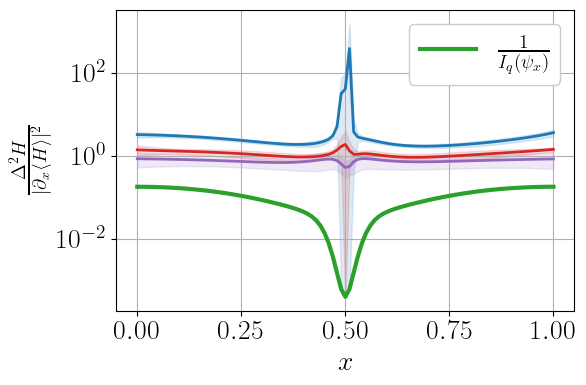

In [53]:
plt.figure(figsize=(6.25, 4.25))
# plt.scatter(labels_train, biass_train**2, s=100)
p_qcnn_4 = plt.plot(labels_test, biass_sq_mean_qcnn_4, color="tab:blue", linewidth=2)
p_qcnn_345 = plt.plot(labels_test, biass_sq_mean_qcnn_345, color="tab:red", linewidth=2)
p_hva_345 = plt.plot(labels_test, biass_sq_mean_hva_345, color="tab:purple", linewidth=2)
f_qcnn_4 = plt.fill_between(labels_test, biass_sq_fill_l_qcnn_4, biass_sq_fill_u_qcnn_4, alpha=0.15, color="tab:blue")
f_qcnn_345 = plt.fill_between(labels_test, biass_sq_fill_l_qcnn_345, biass_sq_fill_u_qcnn_345, alpha=0.15, color="tab:red")
f_hva_345 = plt.fill_between(labels_test, biass_sq_fill_l_hva_345, biass_sq_fill_u_hva_345, alpha=0.15, color="tab:purple")
plt.xlabel(r"$x$")
plt.ylabel(r"$(\mathsf{x} - x)^2$")
# plt.legend()
plt.legend([(p_qcnn_4[0], f_qcnn_4), (p_qcnn_345[0], f_qcnn_345), (p_hva_345[0], f_hva_345)],
           [r'QCNN, $t\in\{5\}$', r'QCNN, $t\in\{4, 5, 6\}$', r'HVA, $t\in\{4, 5, 6\}$'], framealpha=1, loc=2) #, bbox_to_anchor=(0.475, 1)
# plt.yscale("log")
plt.grid()
plt.tight_layout()
# plt.savefig(save_path + file_info + postfix + "-est.pdf", transparent=True, bbox_inches='tight')
plt.show()

plt.figure(figsize=(6.25, 4.25))
# plt.scatter(labels_train, disps_train/expecs_der_train**2, s=150, zorder=10)
plt.plot(labels_test, disps_red_mean_qcnn_4, color="tab:blue", linewidth=2)
plt.plot(labels_test, disps_red_mean_qcnn_345, color="tab:red", linewidth=2)
plt.plot(labels_test, disps_red_mean_hva_345, color="tab:purple", linewidth=2)
plt.fill_between(labels_test, disps_red_fill_l_qcnn_4, disps_red_fill_u_qcnn_4, alpha=0.15, color="tab:blue")
plt.fill_between(labels_test, disps_red_fill_l_qcnn_345, disps_red_fill_u_qcnn_345, alpha=0.15, color="tab:red")
plt.fill_between(labels_test, disps_red_fill_l_hva_345, disps_red_fill_u_hva_345, alpha=0.15, color="tab:purple")
plt.plot(labels_test, 1/QFIs, color="tab:green", label=r"$\frac{1}{I_q(\psi_x)}$", linewidth=3, linestyle="solid") # , color="tab:blue"
# plt.plot(np.sort(labels_test), 1/CFIs_mean, label=r"$\frac{1}{I_c}$", linewidth=1.5, linestyle="dashed", zorder=12) # , color="tab:red"
plt.ylabel(r"$\frac{\Delta^2 H}{|\partial_x \langle H \rangle |^2}$" )
plt.xlabel(r"$x$")
plt.grid()
plt.yscale("log")
plt.legend(framealpha=1)
plt.tight_layout()
# plt.savefig(save_path + file_info + postfix + "-var.pdf", transparent=True, bbox_inches='tight')
plt.show()